# Configuración del entorno



*   Descargar entorno, ficheros, scripts, codigo y dataset de Github
*   Importacion de librerias



In [0]:
!git clone  https://github.com/omar-ogm/keras-ssd 

%cd "/content/keras-ssd"

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pickle

from SSD300.ssd_v2 import SSD300v2
from SSD300.ssd_training import MultiboxLoss
from SSD300.ssd_utils import BBoxUtility

from get_data_from_XML import XML_preprocessor
from generator import Generator



Cloning into 'keras-ssd'...
remote: Enumerating objects: 833, done.
remote: Counting objects: 100% (833/833), done.
remote: Compressing objects: 100% (472/472), done.
remote: Total 833 (delta 363), reused 829 (delta 359), pack-reused 0
Receiving objects: 100% (833/833), 12.03 MiB | 13.65 MiB/s, done.
Resolving deltas: 100% (363/363), done.
/content/keras-ssd


Using TensorFlow backend.


# Carga del modelo SSD300


*   Creacion del modelo
*   Determinar el numero de clases
*  Eleccion de la funcion de perdida
*  Eleccion del optimizador




In [0]:
voc_classes = ['RBC', 'WBC', 'Platelets']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3) #Se puede aumentar para tener mas precision


model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss

model.compile(optimizer='Adam', loss=loss,  metrics=['accuracy']) 
  
  
#https://keras.io/metrics/
#model.compile(optimizer='Adadelta', loss=loss,  metrics=['accuracy']) 
#Añadir mAp en metrics, se pueden añadir métodos para que sean llamados cada vez
#tambien añadir la IoU media o algo así si no es mucho lio

# model.summary()

# Preprocesado 

*   Carga de los prior boxes segun el Paper original. 7308 prior boxes
*   Generacion del groundtruth parseando el XML a formato [class x y width height]




In [0]:
priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [0]:
#Converts from VOC .xml Annotations to labels format (class x y width height)
voc_parser = XML_preprocessor(data_path='./dataset_rbc/train/Annotations/')

# Entrenamiento del modelo

### Creacion de generador de muestra y entrenamiento

* Configuramos los parámetros del entrenamiento
* Se divide la muestra entre train y validation.
* Se usa data agumentation para obtener mejores resultados en el entrenamiento.

In [0]:
from sklearn.model_selection import train_test_split

EPOCHS = 32
BATCH_SIZE = 16

keys = list(voc_parser.data.keys())

train_keys, val_keys = train_test_split(keys, test_size=0.20, random_state=42) #Shuffle and split the data

# Creamos un generator, para ir pasando las imagenes poco a poco y en caso de querer poder aplicar data augmentation sobre la muestra.
# NOTA: Al generator se le pasa el groundtruth de la muestra completa, al ser un diccionario, internamente es capaz de recuperar el groundtruth para cada dato de train y test. 
# En conclusion no es necesario hacer el split para el Y o groundtruth, tan solo para las imagenes
gen = Generator(gt=voc_parser.data, bbox_util=bbox_util,
               batch_size=BATCH_SIZE, path_prefix='./dataset_rbc/train/images/',
               train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))
  
# El generador hace data augmentation sobre las muestras originales de forma aleatoria.
# Método generate() de Generator.py
# Submuestrea de forma aleatoria y selecciona una submuestra de tamaño batch_size de la original
# Aplica un recorte sobre la imagen original y le hace un resize a 300x300 para poder ser admitida por la red.
# De forma aleatoria aplica distintas transformaciones sobre la imagen resultante: flips, cambios en iluminacion, contraste...
# De la misma forma se recalculan los bbox del ground truth para que tengan sentido con la nueva muestra.
# Se hace esto mismo para la validación, de forma que los datos de validacion tambien son aleatorios.
# Esto hace que tengamos muestra "infinita", o al menos mucha mayor muestra que la que teniamos inicialmente la cual no era mucha.
  


### Entrenamiento

* Entrenamos el modelo a través del dataugmentation configurado previamente.
* El entrenamiento se detendrá en caso de pasar 5 epocas sin disminuir el error de perdida para la validación.
* Guardamos el mejor modelo de manera iterativa, es decir, solo sobreviven los modelos con un error de validación menor.

In [0]:
RUN = RUN + 1 if 'RUN' in locals() else 1

LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

tbCallBack = TensorBoard(log_dir=LOG_DIR, write_images=True)

# Vamos guardando todos aquellos modelos que consigan mejorar la val_loss.
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
# Nos centramos en obtener un buen val_loss, en el momento en el que el val_loss deja de crecer durante varias epocas podemos asumir que es porque se ha llegado al punto donde la red 
# empieza a sobreentrenar.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
  
history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches / 4),
                               validation_data=gen.generate(False), validation_steps=int(gen.val_batches / 4),
                               epochs=EPOCHS, verbose=1, callbacks=[tbCallBack, checkpoint, early_stopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/32


/content/keras-ssd/SSD300/ssd_utils.py:114: RuntimeWarning: divide by zero encountered in log
  assigned_priors_wh)


65/65 [==============================] - 90s 1s/step - loss: 17.6167 - acc: 0.2179 - val_loss: 3.0821 - val_acc: 0.3470

Epoch 00001: val_loss improved from inf to 3.08213, saving model to /output/training_logs/run1/checkpoint-01-3.0821.hdf5
Epoch 2/32
65/65 [==============================] - 73s 1s/step - loss: 2.9132 - acc: 0.1576 - val_loss: 2.9235 - val_acc: 0.0168

Epoch 00002: val_loss improved from 3.08213 to 2.92346, saving model to /output/training_logs/run1/checkpoint-02-2.9235.hdf5
Epoch 3/32
29/65 [============>.................] - ETA: 39s - loss: 2.8449 - acc: 0.1829

KeyboardInterrupt: ignored

# Test del modelo final

## Detección

Realizamos la predicción y detección de nuestras clases.

En primer lugar cargaremos los targets de nuestro dataset de test, una vez cargados los target se cargan las imágenes asoaciadas a los mismos. Para finalmente realizar la predicción y detección de los bounding boxes que contengan las clases buscadas.

El método __detection_out__ es el encargado de realizar non maximal supressión sobre las predicciónes para obtener los mejores resultados de detección.

In [0]:
from get_label_from_XML import XML_labels
from keras.preprocessing import image
import imageio
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
from metrics.labels import FileLabels

# Load target
y_test = XML_labels(data_path='./dataset_rbc/test/Annotations/')
keys = list(y_test.data.keys())

# Load the images belonging to the labels
inputs = []
images = []
for key in keys:
  img_path = './dataset_rbc/test/images/' + key
  img = image.load_img(img_path, target_size=(300, 300))
  img = image.img_to_array(img)
  
  images.append(img_path)
  inputs.append(img.copy())

# Predict  
inputs = preprocess_input(np.array(inputs))
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

36/36 [==============================] - 3s 89ms/step


### Creación de etiqueas para el groundtruth

Crearemos un fichero de etiquetas para el groundtruth y posteriormente para las detecciones realizadas, con el fin de medir el rendimiento a través de las métricas __AP__ y __mAP__.

Creamos la función __get_cell_class__ para la creación de las etiquetas asociadas a los vectores one hot que nos informan de la clase a la que pertenece cada objeto detectado.

In [0]:
def get_cell_class(one_hot_vector):
  
  if one_hot_vector[0] == '1':
    name = 'RBC'
  elif one_hot_vector[1] == '1':
    name = 'WBC'
  elif one_hot_vector[2] == '1':
    name = 'Platelets'
    
  return name

Nos apoyaremos en la función anterior y en el módulo __labels__ para generar los ficheros de etiquetas asociadnos a cada imagen de test (groundtruth).

In [0]:
from metrics.labels import FileLabels

# Create/Reset de path to groundtruth
fl = FileLabels('./labels/groundtruths/')

# Create the label files (class_name | x | y | w | h)
for bbox in keys:
  filename = bbox.replace('.jpg', '')
  fl.create(filename)
  for item in y_test.data[bbox]:
    cell_class = get_cell_class(item[4:])
    fl.append(cell_class, None, item[0], item[1], item[2], item[3])
  fl.save()  

## Resultados



1.   En base a las predicciones realizadas mostramos mediante matplotlib los bounding boxes correspondientes a la detección de las distintcas clases.
2.   Al mismo tiempo que obtenemos los bounding boxes creamos los ficheros de etiquetas necesarios para el cálculo de las métricas __AP__ y __mAP__.
3.   Finalmente mostramos los resultados de la detección.

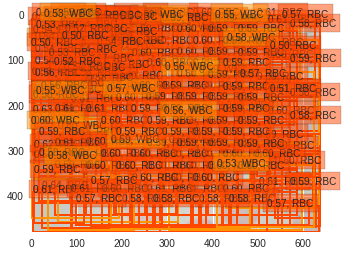

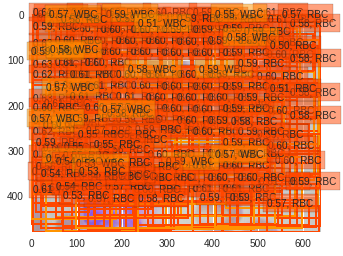

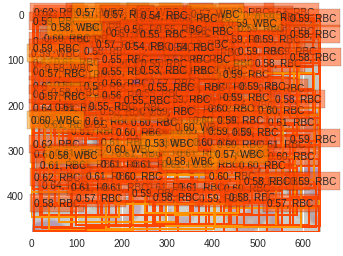

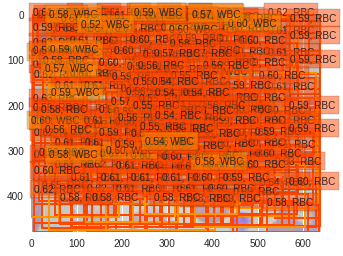

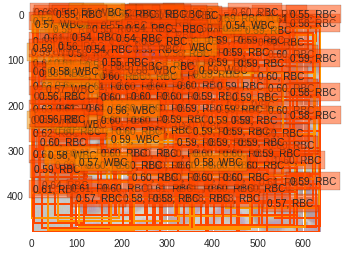

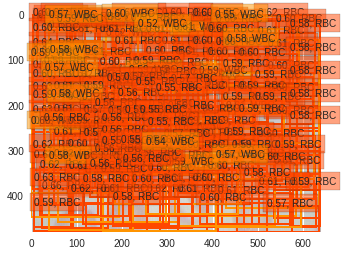

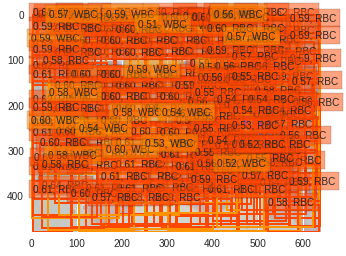

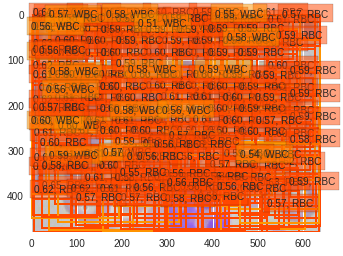

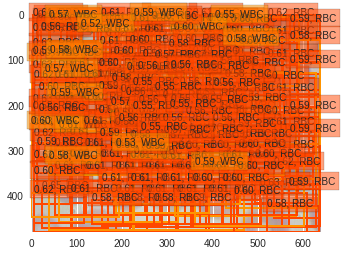

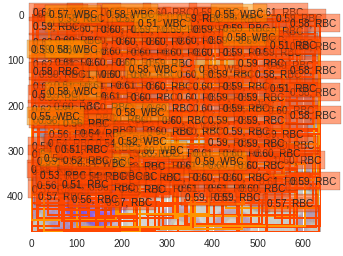

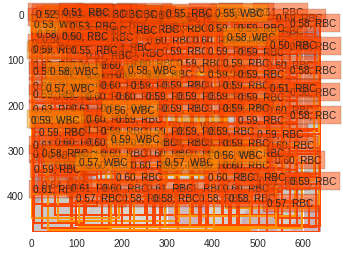

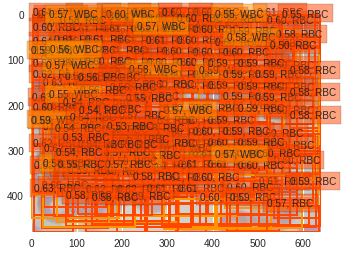

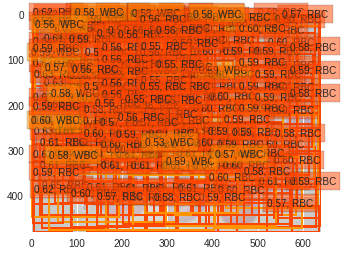

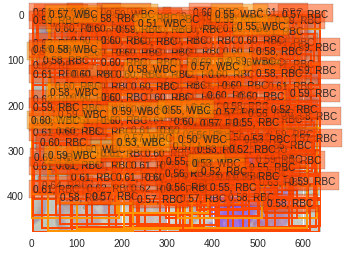

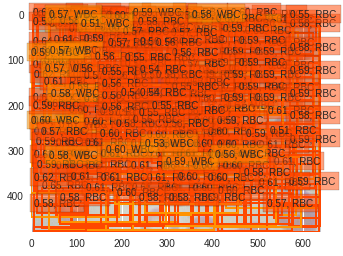

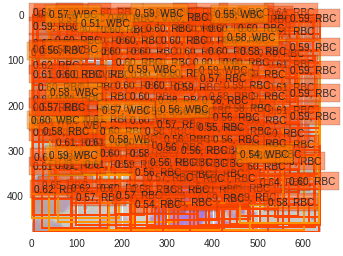

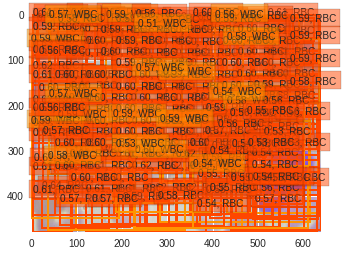

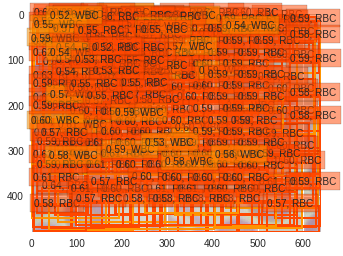

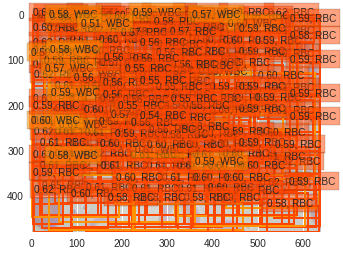

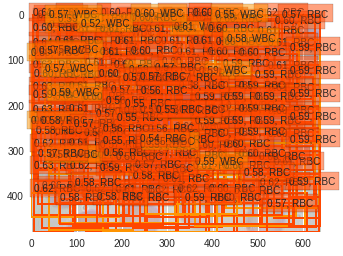

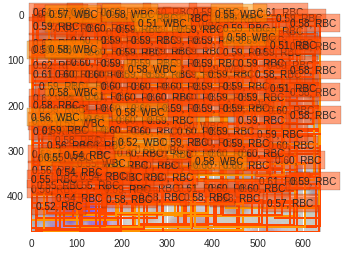

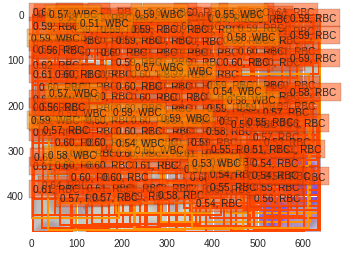

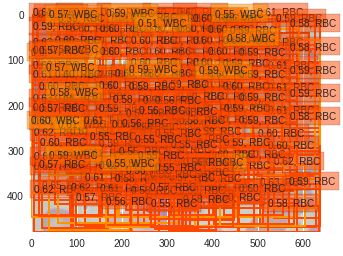

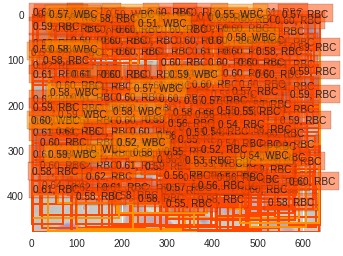

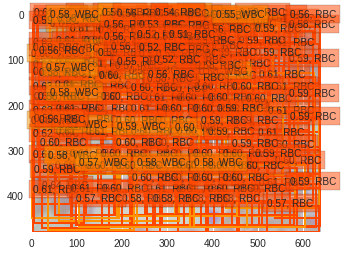

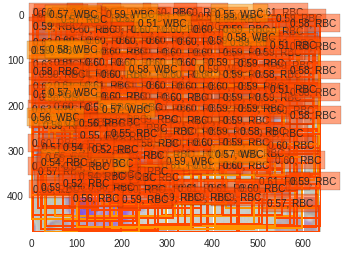

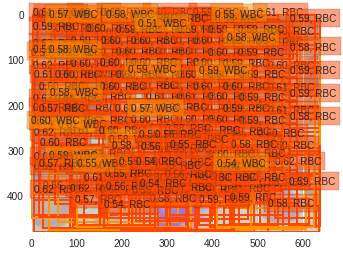

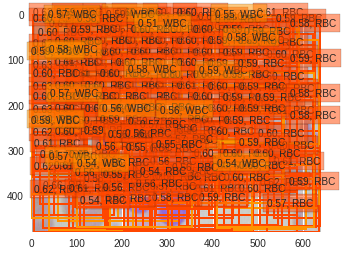

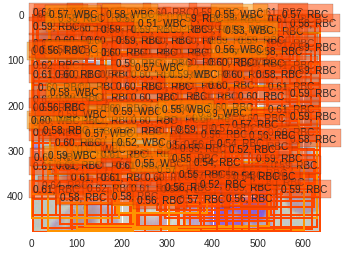

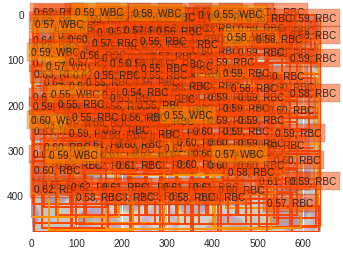

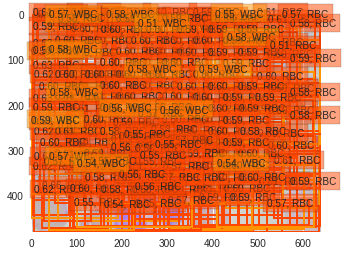

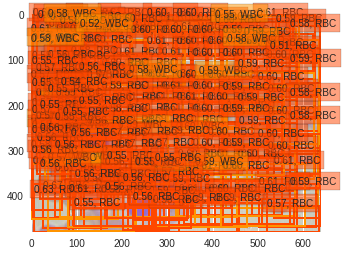

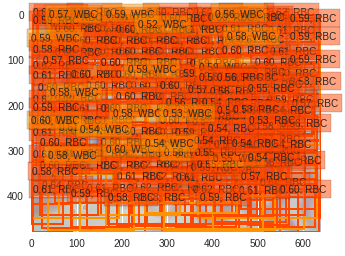

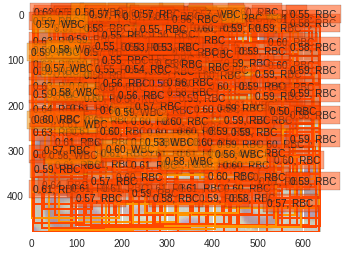

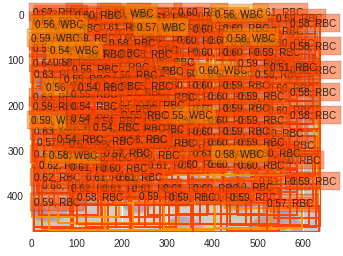

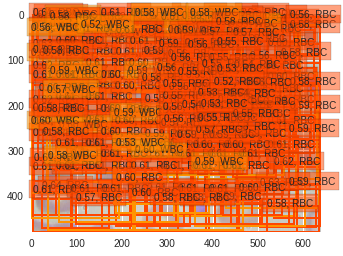

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create/Reset de path to detections
fl = FileLabels('./labels/detections/')

for i, img_path in enumerate(images):
  filename = img_path.split('/')[-1].replace('.jpg', '')
  fl.create(filename)
  
  img = imageio.imread(img_path)  
  
  # Parse the outputs.
  det_label = results[i][:, 0]
  det_conf = results[i][:, 1]
  det_xmin = results[i][:, 2]
  det_ymin = results[i][:, 3]
  det_xmax = results[i][:, 4]
  det_ymax = results[i][:, 5]

  # Get detections with confidence higher than 0.6.
  top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

  top_conf = det_conf[top_indices]
  top_label_indices = det_label[top_indices].tolist()
  top_xmin = det_xmin[top_indices]
  top_ymin = det_ymin[top_indices]
  top_xmax = det_xmax[top_indices]
  top_ymax = det_ymax[top_indices]

  colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

  plt.imshow(img / 255.)
  currentAxis = plt.gca()

  for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = voc_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    # Create the label files (class_name | x | y | w | h)
    fl.append(label_name, score, xmin, ymin, xmax, ymax)
  
  # Save de label detection file
  fl.save()    
  plt.show()

## Rendimiento

Calculamos el __AP__ para cada una de las clases y el __mAP__ global. Para ello nos basamos en el módulo __metrics__. Mostramos las gráficas correspondientes a cada clase y los porcentajes obtenidos.

Los datos obtenidos estan entorno a:
* AP: 87.96% (Platelets)
* AP: 93.89% (RBC)
* AP: 100.00% (WBC)
* mAP: 93.95%

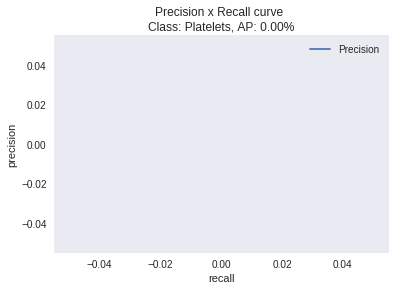

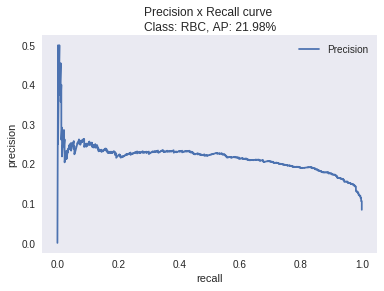

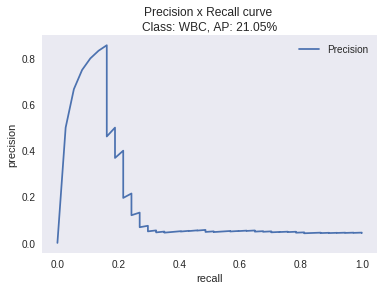

AP: 0.00% (Platelets)
AP: 21.98% (RBC)
AP: 21.05% (WBC)
mAP: 14.34%


In [0]:
import os
from metrics.metrics import Metrics

currentPath = os.path.dirname(os.path.abspath('__file__'))

m = Metrics(currentPath=currentPath,
            gtFormat='xywh',
            detFormat='xywh',
            gtFolder=os.path.join(currentPath, 'labels/groundtruths'),
            gtCoordinates='abs',
            detCoordinates='abs',
            imgSize=None,
            detFolder=os.path.join(currentPath, 'labels/detections'),
            iouThreshold=0.5
            )

m.run()
